In [1]:
#Disclaimer: Este código fue hecho con la ayuda de Cursor, mi autoría está mayormente en la interpretación y la explicación de los resultados.

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings

# Configuración para mejor visualización
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Librerías importadas correctamente")

Librerías importadas correctamente


✅ Accounts cargado: 500 registros
✅ Portfolio cargado: 1225 registros
✅ Transactions cargado: 4658 registros

🔍 ANÁLISIS DE CALIDAD DE DATOS:
�� ESTADÍSTICAS DE INCONSISTENCIAS:
   - Total de cuentas: 500
   - Cuentas con portfolio antes de creación: 229 (45.8%)
   - Cuentas con transacciones antes de creación: 0 (0.0%)


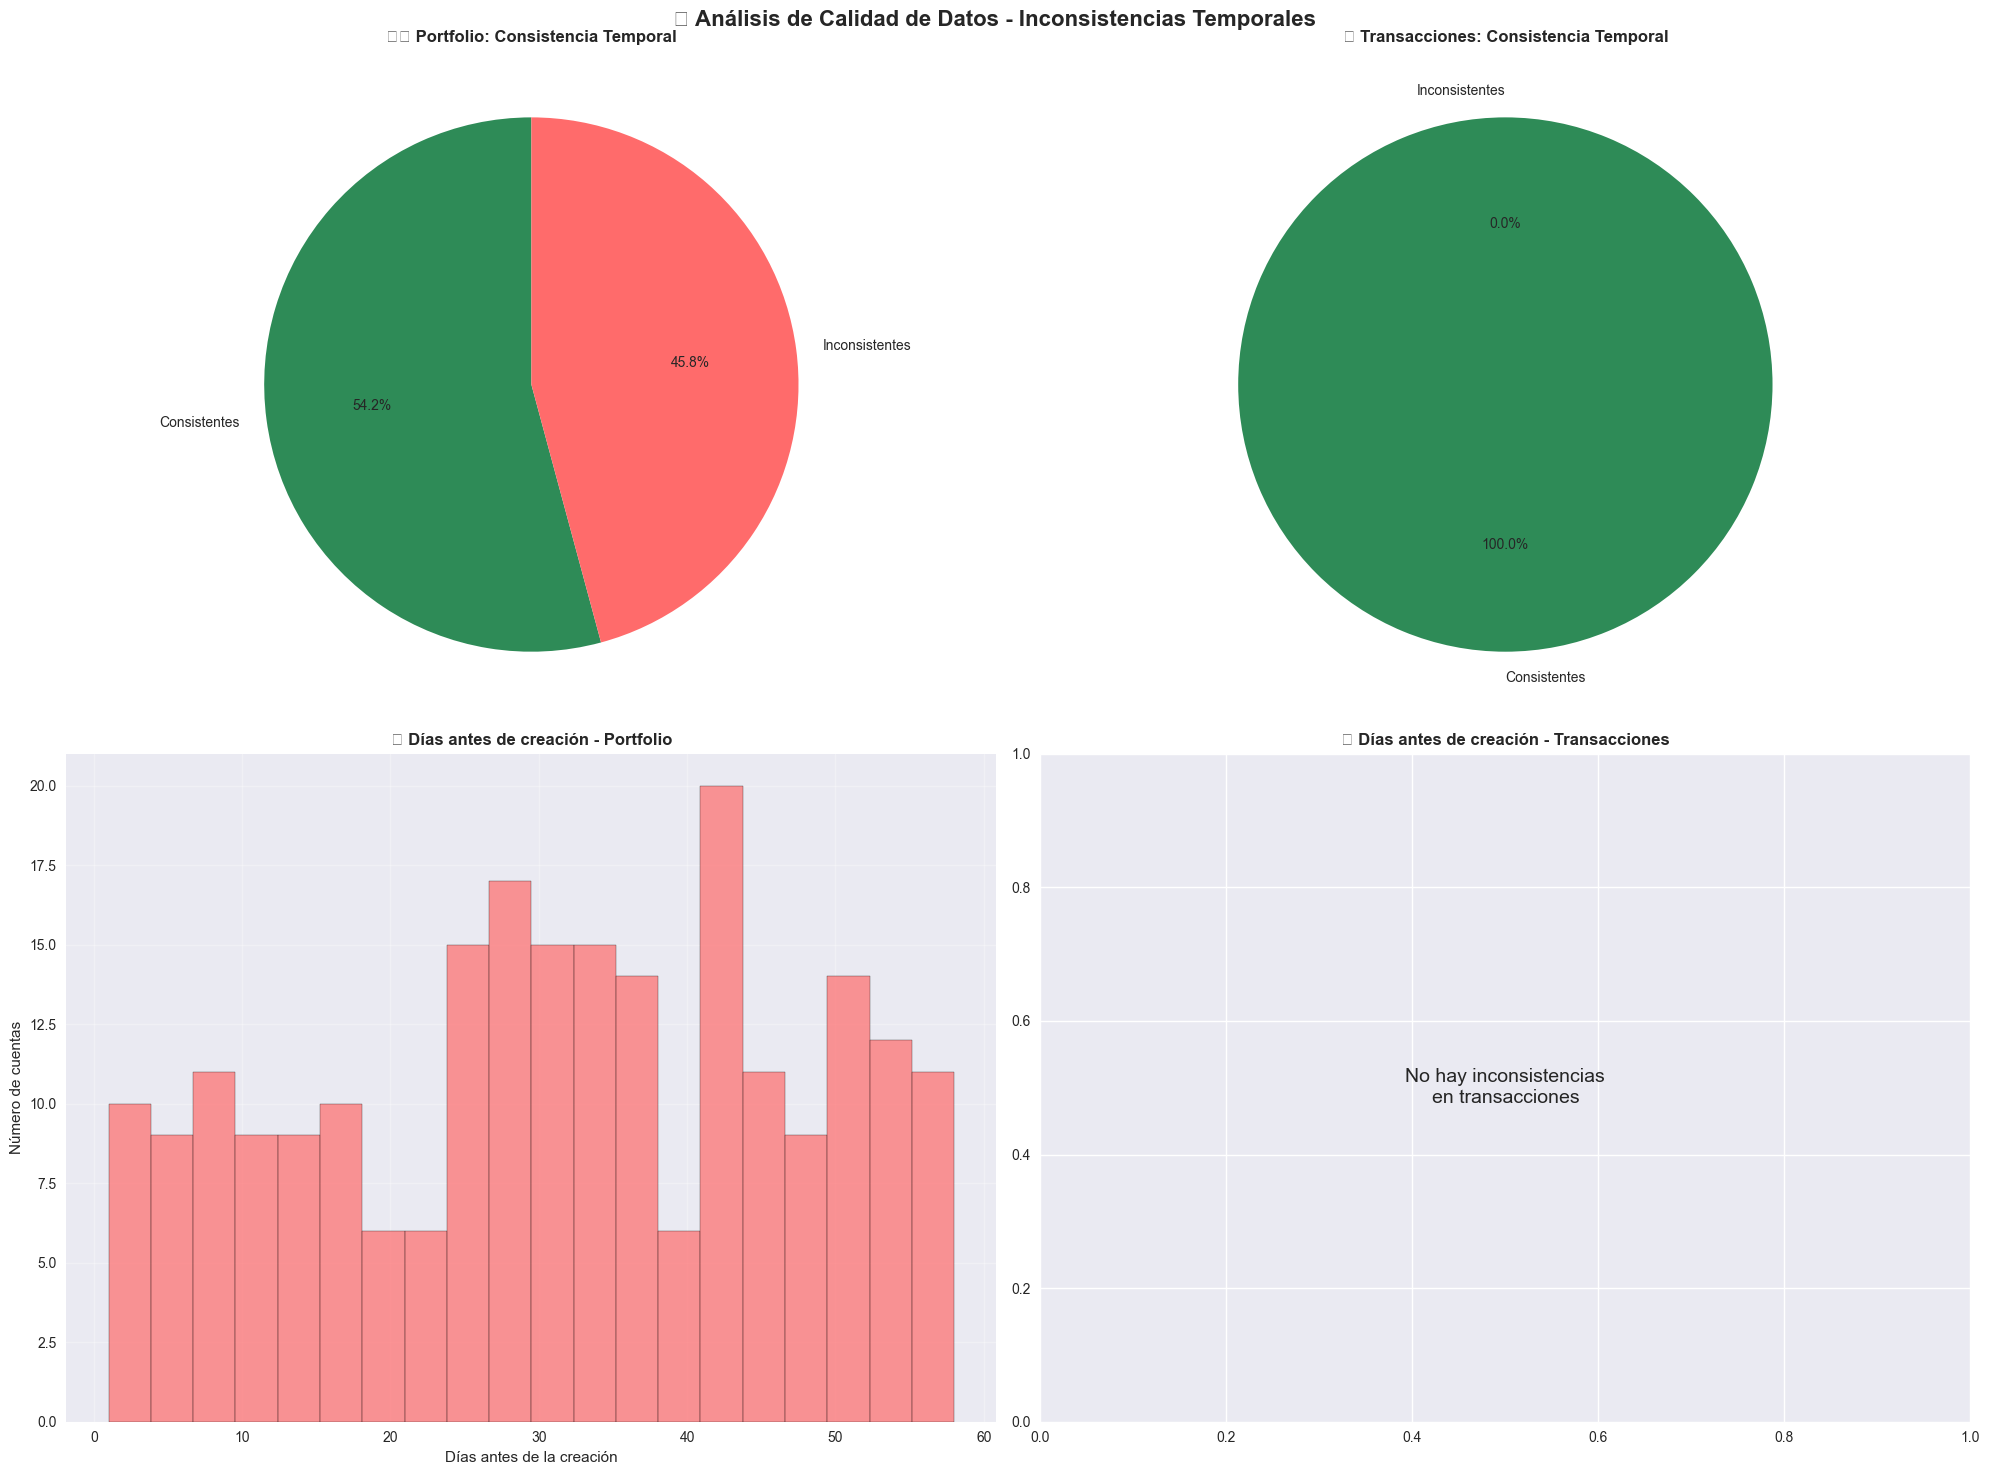


�� EJEMPLOS DE INCONSISTENCIAS:

�� Portfolio antes de creación (primeras 5):
   1. Cuenta 1001: Portfolio 2024-01-31 (creada 2024-03-12, 41 días antes)
   2. Cuenta 1003: Portfolio 2024-01-31 (creada 2024-03-02, 31 días antes)
   3. Cuenta 1005: Portfolio 2024-01-31 (creada 2024-03-16, 45 días antes)
   4. Cuenta 1006: Portfolio 2024-01-31 (creada 2024-02-10, 10 días antes)
   5. Cuenta 1009: Portfolio 2024-01-31 (creada 2024-03-12, 41 días antes)

⚠️  IMPACTO EN EL ANÁLISIS DE COHORTES:
   - 45.8% de las cuentas pueden tener cohortes incorrectas
   - 0.0% de las cuentas pueden tener actividad pre-registro
   - Recomendación: Considerar estas inconsistencias al interpretar resultados

✅ Análisis de calidad de datos completado


In [66]:
# Cargar los archivos CSV
try:
    # Cargar cuentas
    accounts_df = pd.read_csv('data/accounts_202508251759.csv')
    print(f"✅ Accounts cargado: {len(accounts_df)} registros")
    
    # Cargar portafolio
    portfolio_df = pd.read_csv('data/portfolio_202508251801.csv')
    print(f"✅ Portfolio cargado: {len(portfolio_df)} registros")
    
    # Cargar transacciones
    transactions_df = pd.read_csv('data/transactions_202508251802.csv')
    print(f"✅ Transactions cargado: {len(transactions_df)} registros")
    
except FileNotFoundError as e:
    print(f"❌ Error al cargar archivos: {e}")
    print("Asegúrate de que los archivos CSV estén en la carpeta 'data/'")

# ===== VALIDACIÓN TEMPORAL + VISUALIZACIÓN =====
print("\n🔍 ANÁLISIS DE CALIDAD DE DATOS:")
print("=" * 50)

# Convertir fechas primero para poder comparar
accounts_df['creation_date'] = pd.to_datetime(accounts_df['creation_date'])
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
transactions_df['execution_date'] = pd.to_datetime(transactions_df['execution_date'])

# Análisis de inconsistencias temporales
inconsistent_portfolio = []
inconsistent_transactions = []
total_accounts = len(accounts_df)

for _, account in accounts_df.iterrows():
    account_id = account['id_account']
    creation_date = account['creation_date']
    
    # Portfolio antes de la creación
    earlier_portfolio = portfolio_df[
        (portfolio_df['id_account'] == account_id) & 
        (portfolio_df['date'] < creation_date)
    ]
    
    # Transacciones antes de la creación
    earlier_transactions = transactions_df[
        (transactions_df['id_account'] == account_id) & 
        (transactions_df['execution_date'] < creation_date)
    ]
    
    if len(earlier_portfolio) > 0:
        inconsistent_portfolio.append({
            'account_id': account_id,
            'creation_date': creation_date,
            'earliest_portfolio': earlier_portfolio['date'].min(),
            'days_before': (creation_date - earlier_portfolio['date'].min()).days
        })
    
    if len(earlier_transactions) > 0:
        inconsistent_transactions.append({
            'account_id': account_id,
            'creation_date': creation_date,
            'earliest_transaction': earlier_transactions['execution_date'].min(),
            'days_before': (creation_date - earlier_transactions['execution_date'].min()).days
        })

# Calcular estadísticas
portfolio_inconsistency_rate = (len(inconsistent_portfolio) / total_accounts) * 100
transaction_inconsistency_rate = (len(inconsistent_transactions) / total_accounts) * 100

print(f"�� ESTADÍSTICAS DE INCONSISTENCIAS:")
print(f"   - Total de cuentas: {total_accounts:,}")
print(f"   - Cuentas con portfolio antes de creación: {len(inconsistent_portfolio):,} ({portfolio_inconsistency_rate:.1f}%)")
print(f"   - Cuentas con transacciones antes de creación: {len(inconsistent_transactions):,} ({transaction_inconsistency_rate:.1f}%)")

# Crear visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('🔍 Análisis de Calidad de Datos - Inconsistencias Temporales', fontsize=16, fontweight='bold')

# 1. Gráfico de dona - Portfolio antes de creación
portfolio_labels = ['Consistentes', 'Inconsistentes']
portfolio_sizes = [total_accounts - len(inconsistent_portfolio), len(inconsistent_portfolio)]
portfolio_colors = ['#2E8B57', '#FF6B6B']

ax1.pie(portfolio_sizes, labels=portfolio_labels, colors=portfolio_colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('�� Portfolio: Consistencia Temporal', fontweight='bold')

# 2. Gráfico de dona - Transacciones antes de creación
transaction_labels = ['Consistentes', 'Inconsistentes']
transaction_sizes = [total_accounts - len(inconsistent_transactions), len(inconsistent_transactions)]
transaction_colors = ['#2E8B57', '#FF6B6B']

ax2.pie(transaction_sizes, labels=transaction_labels, colors=transaction_colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('💳 Transacciones: Consistencia Temporal', fontweight='bold')

# 3. Histograma de días antes de creación - Portfolio
if inconsistent_portfolio:
    days_before_portfolio = [item['days_before'] for item in inconsistent_portfolio]
    ax3.hist(days_before_portfolio, bins=20, color='#FF6B6B', alpha=0.7, edgecolor='black')
    ax3.set_title('📈 Días antes de creación - Portfolio', fontweight='bold')
    ax3.set_xlabel('Días antes de la creación')
    ax3.set_ylabel('Número de cuentas')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No hay inconsistencias\nen portfolio', ha='center', va='center', transform=ax3.transAxes, fontsize=14)
    ax3.set_title('📈 Días antes de creación - Portfolio', fontweight='bold')

# 4. Histograma de días antes de creación - Transacciones
if inconsistent_transactions:
    days_before_transactions = [item['days_before'] for item in inconsistent_transactions]
    ax4.hist(days_before_transactions, bins=20, color='#FF6B6B', alpha=0.7, edgecolor='black')
    ax4.set_title('📈 Días antes de creación - Transacciones', fontweight='bold')
    ax4.set_xlabel('Días antes de la creación')
    ax4.set_ylabel('Número de cuentas')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No hay inconsistencias\nen transacciones', ha='center', va='center', transform=ax4.transAxes, fontsize=14)
    ax4.set_title('📈 Días antes de creación - Transacciones', fontweight='bold')

plt.tight_layout()
plt.show()

# Mostrar ejemplos de inconsistencias
print(f"\n�� EJEMPLOS DE INCONSISTENCIAS:")
print("=" * 50)

if inconsistent_portfolio:
    print(f"\n�� Portfolio antes de creación (primeras 5):")
    for i, item in enumerate(inconsistent_portfolio[:5], 1):
        print(f"   {i}. Cuenta {item['account_id']}: Portfolio {item['earliest_portfolio'].strftime('%Y-%m-%d')} "
              f"(creada {item['creation_date'].strftime('%Y-%m-%d')}, {item['days_before']} días antes)")

if inconsistent_transactions:
    print(f"\n💳 Transacciones antes de creación (primeras 5):")
    for i, item in enumerate(inconsistent_transactions[:5], 1):
        print(f"   {i}. Cuenta {item['account_id']}: Transacción {item['earliest_transaction'].strftime('%Y-%m-%d')} "
              f"(creada {item['creation_date'].strftime('%Y-%m-%d')}, {item['days_before']} días antes)")

# Resumen de impacto en el análisis
print(f"\n⚠️  IMPACTO EN EL ANÁLISIS DE COHORTES:")
print("=" * 50)
print(f"   - {portfolio_inconsistency_rate:.1f}% de las cuentas pueden tener cohortes incorrectas")
print(f"   - {transaction_inconsistency_rate:.1f}% de las cuentas pueden tener actividad pre-registro")
print(f"   - Recomendación: Considerar estas inconsistencias al interpretar resultados")

print("\n✅ Análisis de calidad de datos completado")

In [67]:
print("INFORMACIÓN GENERAL DE LOS DATASETS")
print("=" * 50)

print("\n1 ACCOUNTS:")
print(f"   - Shape: {accounts_df.shape}")
print(f"   - Columnas: {list(accounts_df.columns)}")
print(f"   - Tipos de datos:\n{accounts_df.dtypes}")
print(f"   - Primeras filas:")
display(accounts_df.head())

print("\n2 PORTFOLIO:")
print(f"   - Shape: {portfolio_df.shape}")
print(f"   - Columnas: {list(portfolio_df.columns)}")
print(f"   - Tipos de datos:\n{portfolio_df.dtypes}")
print(f"   - Primeras filas:")
display(portfolio_df.head())

print("\n3 TRANSACTIONS:")
print(f"   - Shape: {transactions_df.shape}")
print(f"   - Columnas: {list(transactions_df.columns)}")
print(f"   - Tipos de datos:\n{transactions_df.dtypes}")
print(f"   - Primeras filas:")
display(transactions_df.head())

INFORMACIÓN GENERAL DE LOS DATASETS

1 ACCOUNTS:
   - Shape: (500, 2)
   - Columnas: ['id_account', 'creation_date']
   - Tipos de datos:
id_account                int64
creation_date    datetime64[ns]
dtype: object
   - Primeras filas:


,id_account,creation_date
0,1001,2024-03-12
1,1002,2024-01-21
2,1003,2024-03-02
3,1004,2023-12-15
4,1005,2024-03-16



2 PORTFOLIO:
   - Shape: (1225, 5)
   - Columnas: ['id_account', 'date', 'instrument_type', 'quantity', 'value_ars']
   - Tipos de datos:
id_account                  int64
date               datetime64[ns]
instrument_type            object
quantity                  float64
value_ars                 float64
dtype: object
   - Primeras filas:


,id_account,date,instrument_type,quantity,value_ars
0,1001,2024-01-31,stock,2.98,28628.24
1,1001,2024-03-01,stablecoin_usdc,4.03,21146.13
2,1001,2024-03-31,stock,5.30,20757.86
3,1001,2024-04-30,stock,5.83,56213.30
4,1002,2024-01-31,bond,3.11,32825.75



3 TRANSACTIONS:
   - Shape: (4658, 5)
   - Columnas: ['id_account', 'execution_date', 'type', 'amount_ars', 'amount_usd']
   - Tipos de datos:
id_account                 int64
execution_date    datetime64[ns]
type                      object
amount_ars               float64
amount_usd               float64
dtype: object
   - Primeras filas:


,id_account,execution_date,type,amount_ars,amount_usd
0,1001,2024-03-18,invest,5780.0,0.0
1,1001,2024-03-31,invest,7655.0,0.0
2,1001,2024-03-27,deposit,23386.0,0.0
3,1001,2024-06-06,deposit,33097.0,0.0
4,1001,2024-05-16,invest,34621.0,0.0


In [68]:
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)

print("\nPortfolio - Estadísticas por tipo de instrumento:")
portfolio_stats = portfolio_df.groupby('instrument_type').agg({
    'quantity': ['count', 'mean', 'std', 'min', 'max'],
    'value_ars': ['mean', 'std', 'min', 'max']
}).round(2)
display(portfolio_stats)

print("\nTransactions - Estadísticas por tipo:")
transactions_stats = transactions_df.groupby('type').agg({
    'amount_ars': ['count', 'mean', 'std', 'min', 'max'],
    'amount_usd': ['count', 'mean', 'std', 'min', 'max']
}).round(2)
display(transactions_stats)

print("\nAccounts - Estadísticas de fechas de creación:")
accounts_df['creation_date'].describe()

ESTADÍSTICAS DESCRIPTIVAS

Portfolio - Estadísticas por tipo de instrumento:


quantity                         value_ars                    \
                   count  mean   std   min   max      mean       std     min   
instrument_type                                                                
bond                 392  5.25  2.92  0.11  9.98  41281.03  33657.25  255.83   
stablecoin_usdc      426  4.72  2.82  0.11  9.95  36349.34  31857.62  180.29   
stock                407  4.96  2.86  0.21  9.99  40280.92  32893.35  543.14   

                            
                       max  
instrument_type             
bond             127791.49  
stablecoin_usdc  141707.27  
stock            148228.91


Transactions - Estadísticas por tipo:


amount_ars                                       amount_usd  \
                       count      mean       std      min      max      count   
type                                                                            
card_spend               931 -24502.86  14421.53 -49998.0  -1002.0        931   
currency_exchange        455      0.00      0.00      0.0      0.0        455   
deposit                 1388  25964.84  13912.78   1048.0  49994.0       1388   
invest                  1447  25755.86  14234.73   1015.0  49928.0       1447   
withdrawal               437 -24933.62  14036.87 -49888.0  -1022.0        437   

                                                
                     mean     std   min    max  
type                                            
card_spend           0.00    0.00   0.0    0.0  
currency_exchange  255.26  139.76  10.0  499.0  
deposit              0.00    0.00   0.0    0.0  
invest               0.00    0.00   0.0    0.0  
withdrawal           0.00    0.00   0.0    0.0


Accounts - Estadísticas de fechas de creación:


count                    500
mean     2024-01-28 22:33:36
min      2023-12-01 00:00:00
25%      2023-12-30 00:00:00
50%      2024-01-29 00:00:00
75%      2024-03-01 00:00:00
max      2024-03-29 00:00:00
Name: creation_date, dtype: object

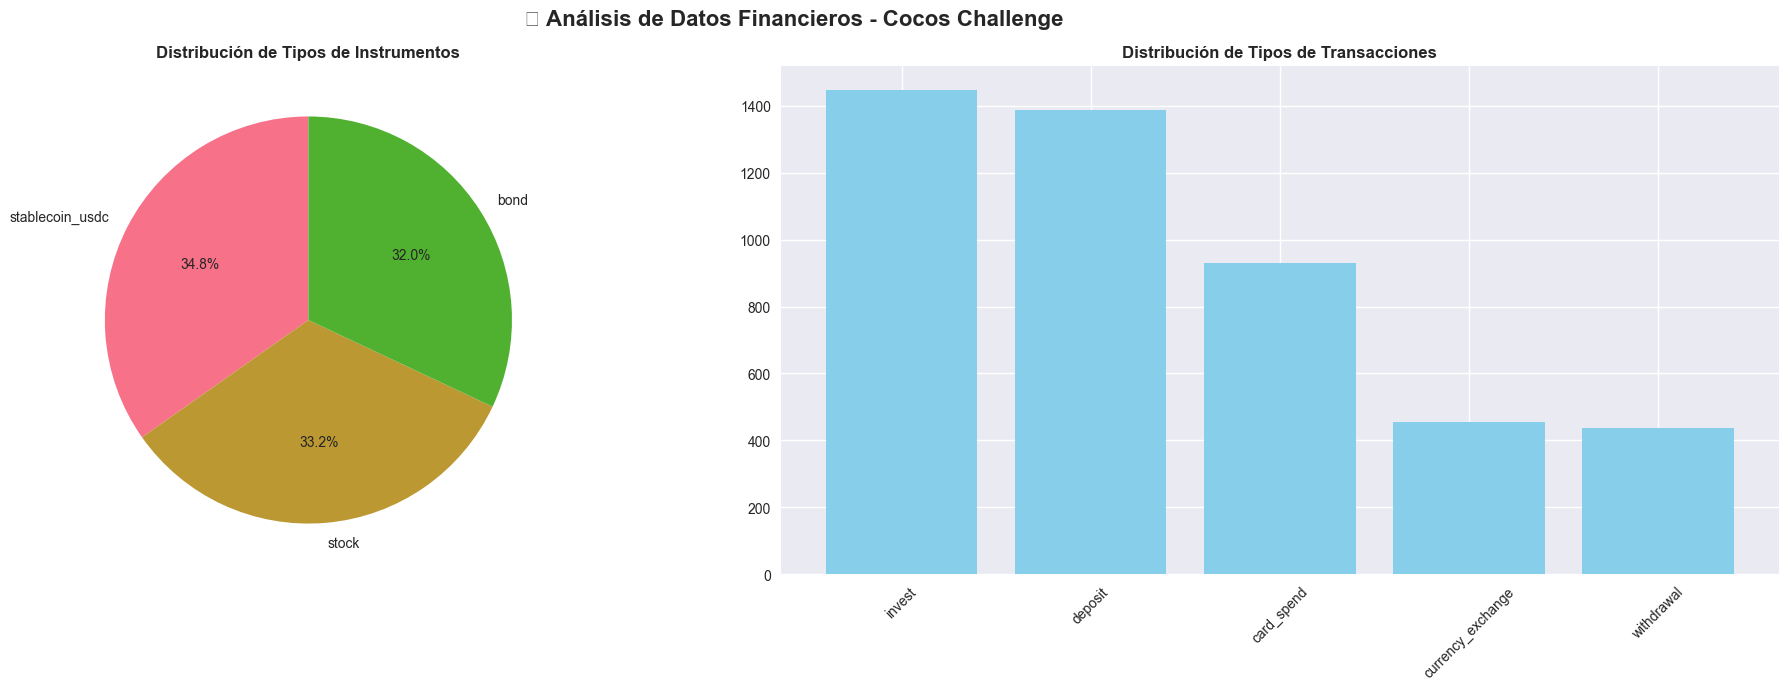

In [69]:
# Configurar el tamaño de las figuras
plt.rcParams['figure.figsize'] = (15, 10)

# Convertir fechas
accounts_df['creation_date'] = pd.to_datetime(accounts_df['creation_date'])
portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
transactions_df['execution_date'] = pd.to_datetime(transactions_df['execution_date'])

# Crear subplots en una sola fila de 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('📊 Análisis de Datos Financieros - Cocos Challenge', fontsize=16, fontweight='bold')

# 1. Distribución de tipos de instrumentos
instrument_counts = portfolio_df['instrument_type'].value_counts()
axes[0].pie(instrument_counts.values, labels=instrument_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribución de Tipos de Instrumentos', fontweight='bold')

# 2. Distribución de tipos de transacciones
transaction_counts = transactions_df['type'].value_counts()
axes[1].bar(transaction_counts.index, transaction_counts.values, color='skyblue')
axes[1].set_title('Distribución de Tipos de Transacciones', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [70]:
# Crear cohortes por mes de alta
# Asegurarse de que 'id_account' y 'creation_date' existen y están limpios
if 'id_account' not in accounts_df.columns or 'creation_date' not in accounts_df.columns:
    raise ValueError("Faltan columnas necesarias en accounts_df")

# Limpiar duplicados por id_account (nos quedamos con la primera aparición)
accounts_df = accounts_df.drop_duplicates(subset=['id_account'])

# Crear cohort_month y cohort_date en accounts_df
accounts_df['cohort_month'] = pd.to_datetime(accounts_df['creation_date']).dt.to_period('M')
accounts_df['cohort_date'] = accounts_df['cohort_month'].apply(lambda p: p.start_time)

# Revisar que no haya valores nulos en id_account
if accounts_df['id_account'].isnull().any():
    raise ValueError("Existen valores nulos en id_account de accounts_df")

# Mostrar tabla de cohortes para entender cómo quedan
print("Tabla de cohortes (primeras filas):")
display(accounts_df[['id_account', 'creation_date', 'cohort_month', 'cohort_date']].head(10))
print(f"Cantidad de cohortes distintas: {accounts_df['cohort_month'].nunique()}")
print("Distribución de usuarios por cohorte:")
display(accounts_df['cohort_month'].value_counts().sort_index())

# Agregar cohorte a transacciones y portfolio
transactions_df = transactions_df.merge(
    accounts_df[['id_account', 'cohort_month', 'cohort_date']],
    on='id_account', how='left', validate='many_to_one'
)

portfolio_df = portfolio_df.merge(
    accounts_df[['id_account', 'cohort_month', 'cohort_date']],
    on='id_account', how='left', validate='many_to_one'
)

# Verificar que las columnas de cohorte existen después del merge
missing_cols = []
if 'cohort_month' not in transactions_df.columns:
    missing_cols.append("transactions_df")
if 'cohort_month' not in portfolio_df.columns:
    missing_cols.append("portfolio_df")
if missing_cols:
    print(f"Advertencia: No se pudo agregar 'cohort_month' a los siguientes dataframes: {', '.join(missing_cols)}")
    print("Columnas actuales en transactions_df:", transactions_df.columns)
    print("Columnas actuales en portfolio_df:", portfolio_df.columns)
else:
    # Calcular meses desde la cohorte solo si las columnas existen
    transactions_df['months_since_cohort'] = (
        transactions_df['execution_date'].dt.to_period('M') - 
        transactions_df['cohort_month']
    ).apply(lambda x: x.n if pd.notnull(x) else None)

    portfolio_df['months_since_cohort'] = (
        portfolio_df['date'].dt.to_period('M') - 
        portfolio_df['cohort_month']
    ).apply(lambda x: x.n if pd.notnull(x) else None)

    print("Datos preparados para análisis de cohortes")
    print(f"Rango de cohortes: {accounts_df['cohort_month'].min()} a {accounts_df['cohort_month'].max()}")

Tabla de cohortes (primeras filas):


,id_account,creation_date,cohort_month,cohort_date
0,1001,2024-03-12,2024-03,2024-03-01
1,1002,2024-01-21,2024-01,2024-01-01
2,1003,2024-03-02,2024-03,2024-03-01
3,1004,2023-12-15,2023-12,2023-12-01
4,1005,2024-03-16,2024-03,2024-03-01
5,1006,2024-02-10,2024-02,2024-02-01
6,1007,2024-01-30,2024-01,2024-01-01
7,1008,2023-12-21,2023-12,2023-12-01
8,1009,2024-03-12,2024-03,2024-03-01
9,1010,2024-02-21,2024-02,2024-02-01


Cantidad de cohortes distintas: 4
Distribución de usuarios por cohorte:


cohort_month
2023-12    129
2024-01    142
2024-02    102
2024-03    127
Freq: M, Name: count, dtype: int64

Datos preparados para análisis de cohortes
Rango de cohortes: 2023-12 a 2024-03


In [71]:
# Métrica 1: Retención por actividad transaccional mensual
def calculate_retention_cohorts():
    """Calcula retención mensual por cohorte basada en transacciones"""

    # Usuarios activos por mes y cohorte
    retention_data = transactions_df.groupby(['cohort_month', 'months_since_cohort'])['id_account'].nunique().reset_index()
    retention_data = retention_data.rename(columns={'id_account': 'active_users'})

    # Usuarios totales por cohorte
    cohort_sizes = accounts_df.groupby('cohort_month')['id_account'].nunique().reset_index()
    cohort_sizes = cohort_sizes.rename(columns={'id_account': 'total_users'})

    # Merge para traer el tamaño de cohorte a cada fila de retention_data
    retention_data = retention_data.merge(cohort_sizes, on='cohort_month', how='left')

    # Calcular tasa de retención
    retention_data['retention_rate'] = (retention_data['active_users'] / retention_data['total_users'] * 100).round(2)

    return retention_data

# Métrica 2: Retención por tenencia de instrumentos (CORREGIDA)
def calculate_portfolio_retention():
    """Calcula retención basada en tenencia de instrumentos"""
    
    # Para cada cohorte, calcular usuarios que mantuvieron portafolio
    portfolio_retention = []
    
    for cohort in portfolio_df['cohort_month'].unique():
        cohort_users = accounts_df[accounts_df['cohort_month'] == cohort]['id_account'].unique()
        total_users = len(cohort_users)
        
        for month in range(0, 4):  # 0, 1, 2, 3 meses
            # Usuarios que tuvieron portafolio en ALGÚN momento hasta ese mes
            month_date = pd.Period(cohort, freq='M') + month
            month_datetime = month_date.to_timestamp()
            
            # Usuarios con portafolio hasta ese mes (inclusive)
            users_with_portfolio = portfolio_df[
                (portfolio_df['cohort_month'] == cohort) & 
                (portfolio_df['date'] <= month_datetime)
            ]['id_account'].nunique()
            
            retention_rate = (users_with_portfolio / total_users * 100) if total_users > 0 else 0
            
            portfolio_retention.append({
                'cohort_month': cohort,
                'months_since_cohort': month,
                'users_with_portfolio': users_with_portfolio,
                'total_users': total_users,
                'portfolio_retention_rate': round(retention_rate, 2)
            })
    
    return pd.DataFrame(portfolio_retention)

# Métrica 3: Retención acumulativa (ALTERNATIVA MÁS CLARA)
def calculate_cumulative_portfolio_retention():
    """Calcula retención ACUMULATIVA del portafolio"""
    
    retention_data = []
    
    for cohort in portfolio_df['cohort_month'].unique():
        cohort_users = accounts_df[accounts_df['cohort_month'] == cohort]['id_account'].unique()
        total_users = len(cohort_users)
        
        for month in range(0, 4):
            # Usuarios que tuvieron portafolio en ALGÚN momento hasta ese mes
            month_date = pd.Period(cohort, freq='M') + month
            month_datetime = month_date.to_timestamp()
            
            # Usuarios que tuvieron portafolio hasta ese mes
            users_with_portfolio = portfolio_df[
                (portfolio_df['cohort_month'] == cohort) & 
                (portfolio_df['date'] <= month_datetime)
            ]['id_account'].nunique()
            
            retention_rate = (users_with_portfolio / total_users * 100) if total_users > 0 else 0
            
            retention_data.append({
                'cohort_month': cohort,
                'months_since_cohort': month,
                'users_with_portfolio': users_with_portfolio,
                'total_users': total_users,
                'cumulative_retention_rate': round(retention_rate, 2)
            })
    
    return pd.DataFrame(retention_data)

# Calcular métricas 
retention_cohorts = calculate_retention_cohorts()
portfolio_retention_cohorts = calculate_portfolio_retention()  
cumulative_portfolio_retention = calculate_cumulative_portfolio_retention()  

print("✅ Métricas de retención calculadas CORRECTAMENTE")

# Calcular métricas
retention_cohorts = calculate_retention_cohorts()
portfolio_retention_cohorts = calculate_portfolio_retention()

print("Métricas de retención calculadas")
print("\nRetención por actividad transaccional (primeras filas):")
print(retention_cohorts.head())

print("\nRetención por tenencia de instrumentos (primeras filas):")
print(portfolio_retention_cohorts.head())

✅ Métricas de retención calculadas CORRECTAMENTE
Métricas de retención calculadas

Retención por actividad transaccional (primeras filas):
  cohort_month  months_since_cohort  active_users  total_users  retention_rate
0      2023-12                    0            87          129           67.44
1      2023-12                    1           116          129           89.92
2      2023-12                    2           116          129           89.92
3      2023-12                    3            61          129           47.29
4      2024-01                    0            81          142           57.04

Retención por tenencia de instrumentos (primeras filas):
  cohort_month  months_since_cohort  users_with_portfolio  total_users  \
0      2024-03                    0                   127          127   
1      2024-03                    1                   127          127   
2      2024-03                    2                   127          127   
3      2024-03                   

In [72]:
# Métrica 1: Valor promedio del portafolio por cohorte
def calculate_portfolio_value_cohorts():
    """Calcula valor promedio del portafolio por cohorte y mes"""

    # Filtrar solo meses válidos: months_since_cohort >= 0
    filtered_portfolio = portfolio_df[portfolio_df['months_since_cohort'] >= 0]

    portfolio_value = filtered_portfolio.groupby(['cohort_month', 'months_since_cohort']).agg({
        'value_ars': ['mean', 'sum', 'count']
    }).reset_index()

    portfolio_value.columns = ['cohort_month', 'months_since_cohort', 'avg_value', 'total_value', 'positions_count']

    # Agregar tamaño de cohorte
    cohort_sizes = accounts_df.groupby('cohort_month')['id_account'].nunique().reset_index()
    portfolio_value = portfolio_value.merge(cohort_sizes, on='cohort_month', how='left')
    portfolio_value = portfolio_value.rename(columns={'id_account': 'total_users'})

    return portfolio_value

# Métrica 2: Volumen de transacciones por cohorte
def calculate_transaction_volume_cohorts():
    """Calcula volumen de transacciones por cohorte y mes"""
    
    transaction_volume = transactions_df.groupby(['cohort_month', 'months_since_cohort']).agg({
        'amount_ars': ['sum', 'mean', 'count']
    }).reset_index()
    
    transaction_volume.columns = ['cohort_month', 'months_since_cohort', 'total_volume', 'avg_transaction', 'transaction_count']
    
    # Agregar tamaño de cohorte
    cohort_sizes = accounts_df.groupby('cohort_month')['id_account'].nunique().reset_index()
    transaction_volume = transaction_volume.merge(cohort_sizes, on='cohort_month', how='left')
    transaction_volume = transaction_volume.rename(columns={'id_account': 'total_users'})
    
    return transaction_volume

# Métrica 3: Valor por usuario activo (ARPU)
def calculate_arpu_cohorts():
    """Calcula Average Revenue Per User por cohorte y mes"""
    
    # Valor del portafolio por usuario activo
    arpu_portfolio = portfolio_df.groupby(['cohort_month', 'months_since_cohort', 'id_account'])['value_ars'].sum().reset_index()
    arpu_portfolio = arpu_portfolio.groupby(['cohort_month', 'months_since_cohort'])['value_ars'].mean().reset_index()
    arpu_portfolio = arpu_portfolio.rename(columns={'value_ars': 'avg_portfolio_per_user'})
    
    # Volumen de transacciones por usuario activo
    arpu_transactions = transactions_df.groupby(['cohort_month', 'months_since_cohort', 'id_account'])['amount_ars'].sum().reset_index()
    arpu_transactions = arpu_transactions.groupby(['cohort_month', 'months_since_cohort'])['amount_ars'].mean().reset_index()
    arpu_transactions = arpu_transactions.rename(columns={'amount_ars': 'avg_transactions_per_user'})
    
    # Merge
    arpu = arpu_portfolio.merge(arpu_transactions, on=['cohort_month', 'months_since_cohort'], how='outer')
    arpu = arpu.fillna(0)
    
    return arpu

# Calcular métricas de valor
portfolio_values = calculate_portfolio_value_cohorts()
transaction_volumes = calculate_transaction_volume_cohorts()
arpu_metrics = calculate_arpu_cohorts()

print("Métricas de valor generado calculadas")

# Mostramos un poco de cada una para entender qué se fue guardando
print("\nPortfolio values (primeras filas):")
print(portfolio_values.head())

print("\nTransaction volumes (primeras filas):")
print(transaction_volumes.head())

print("\nARPU metrics (primeras filas):")
print(arpu_metrics.head())

Métricas de valor generado calculadas

Portfolio values (primeras filas):
  cohort_month  months_since_cohort     avg_value  total_value  \
0      2023-12                    1  39360.026589   5077443.43   
1      2023-12                    3  38693.005541   6074801.87   
2      2023-12                    4  42912.896452   1330299.79   
3      2024-01                    0  37124.410986   5271666.36   
4      2024-01                    2  38616.625028   6989609.13   

   positions_count  total_users  
0              129          129  
1              157          129  
2               31          129  
3              142          142  
4              181          142  

Transaction volumes (primeras filas):
  cohort_month  months_since_cohort  total_volume  avg_transaction  \
0      2023-12                    0     1857778.0      8330.843049   
1      2023-12                    1     2951335.0      7060.610048   
2      2023-12                    2     3485225.0      9171.644737   
3     

In [73]:
# Crear matriz de retención clásica
def create_retention_matrix():
    """Crea matriz de retención por cohorte"""
    
    # Pivotar datos de retención
    retention_matrix = retention_cohorts.pivot(
        index='cohort_month', 
        columns='months_since_cohort', 
        values='retention_rate'
    )
    
    # Ordenar por fecha de cohorte
    retention_matrix = retention_matrix.sort_index(ascending=False)
    
    return retention_matrix

# Crear matriz de retención de portafolio
def create_portfolio_retention_matrix():
    """Crea matriz de retención de portafolio por cohorte, asegurando columnas 0-3 en cada cohorte"""
    
    # Pivotar la matriz normalmente
    portfolio_matrix = cumulative_portfolio_retention.pivot(
        index='cohort_month', 
        columns='months_since_cohort', 
        values='cumulative_retention_rate'
    )
    
    # Asegurar que todas las cohortes tengan columnas de 0 a 3 (aunque falten datos)
    expected_cols = list(range(4))  # 0, 1, 2, 3
    portfolio_matrix = portfolio_matrix.reindex(columns=expected_cols)
    
    # Ordenar por fecha de cohorte descendente
    portfolio_matrix = portfolio_matrix.sort_index(ascending=False)
    
    return portfolio_matrix

# Crear matrices
retention_matrix = create_retention_matrix()
portfolio_matrix = create_portfolio_retention_matrix()

print("Matrices de retención creadas")
print("\nMatriz de retención por actividad transaccional:")
display(retention_matrix)
print("\nMatriz de retención por tenencia de portafolio:")
display(portfolio_matrix)

Matrices de retención creadas

Matriz de retención por actividad transaccional:


months_since_cohort,0,1,2,3
cohort_month,,,,
2024-03,71.65,82.68,89.76,58.27
2024-02,54.90,89.22,82.35,55.88
2024-01,57.04,84.51,86.62,59.15
2023-12,67.44,89.92,89.92,47.29



Matriz de retención por tenencia de portafolio:


months_since_cohort,0,1,2,3
cohort_month,,,,
2024-03,100.0,100.0,100.0,100.0
2024-02,100.0,100.0,100.0,100.0
2024-01,0.0,100.0,100.0,100.0
2023-12,0.0,0.0,100.0,100.0


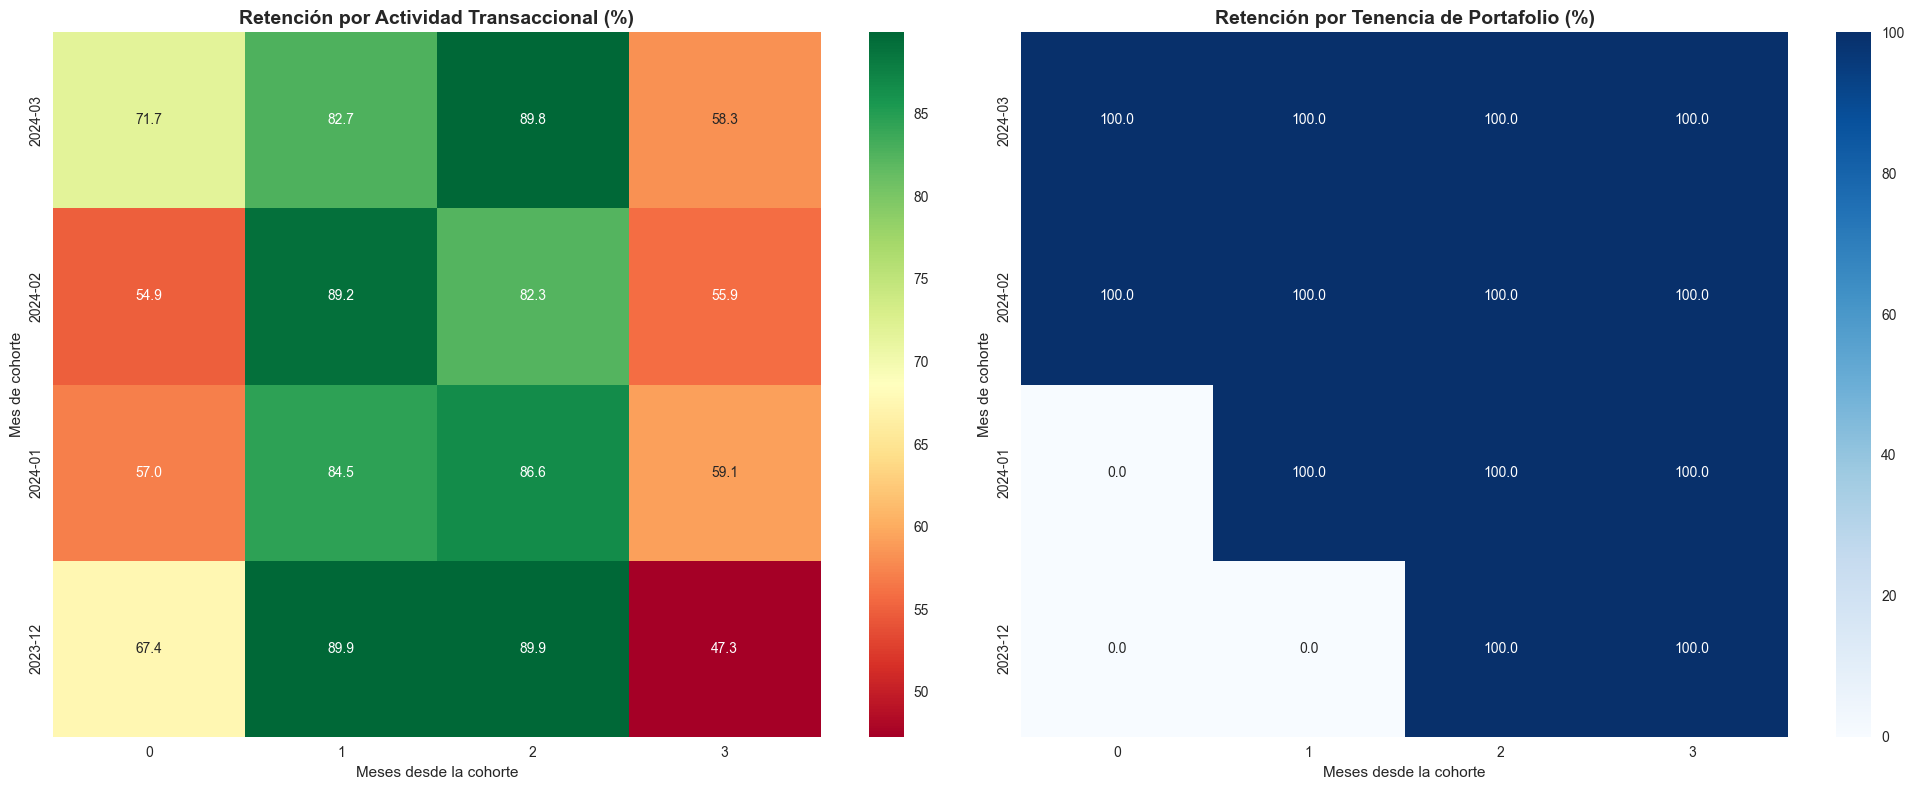

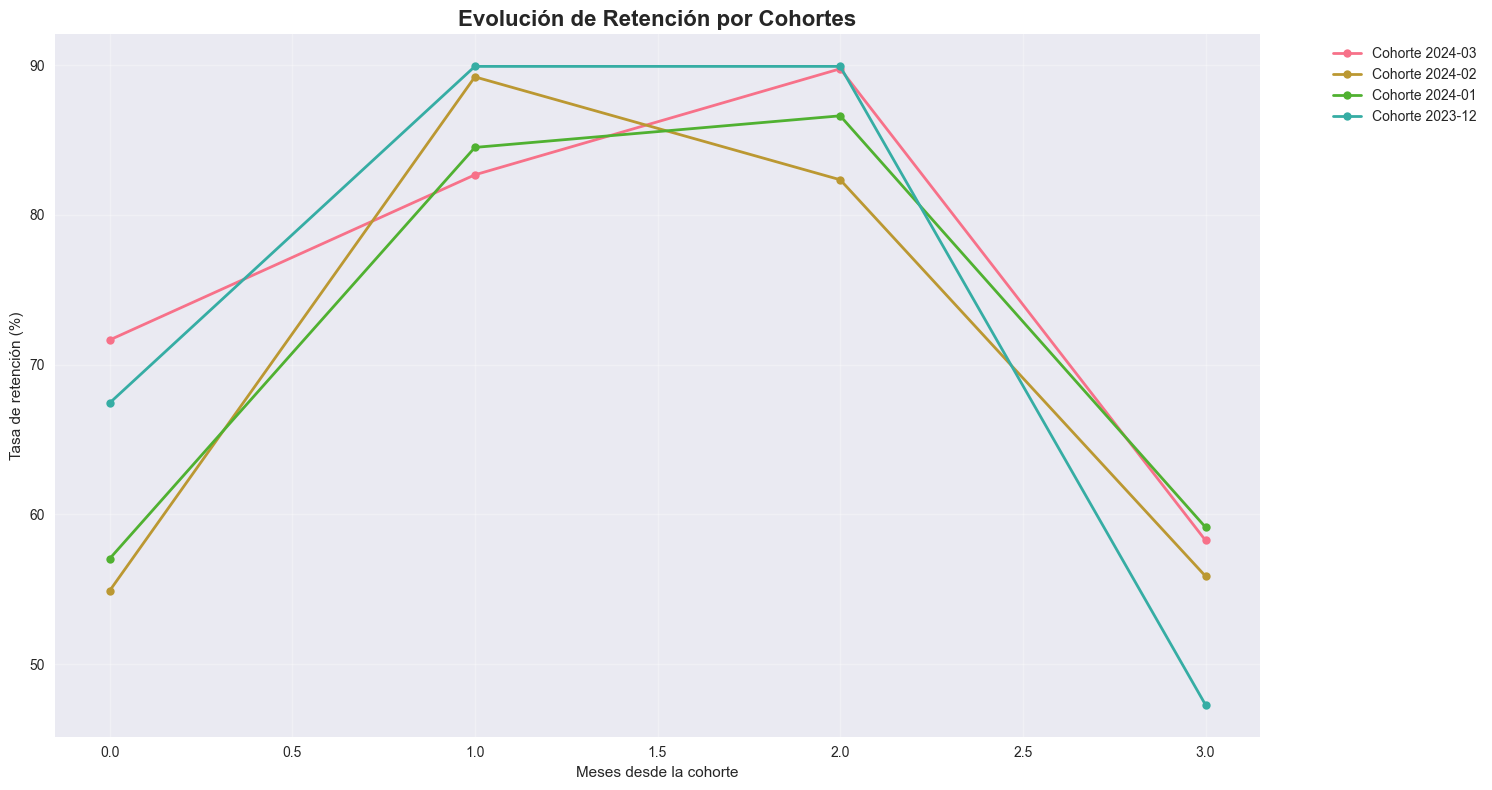

In [79]:
# Configurar gráficos
plt.rcParams['figure.figsize'] = (16, 12)

# 1. Heatmap de retención
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap de retención transaccional
sns.heatmap(retention_matrix, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1)
ax1.set_title('Retención por Actividad Transaccional (%)', fontweight='bold', fontsize=14)
ax1.set_xlabel('Meses desde la cohorte')
ax1.set_ylabel('Mes de cohorte')

# Heatmap de retención de portafolio
sns.heatmap(portfolio_matrix, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
ax2.set_title('Retención por Tenencia de Portafolio (%)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Meses desde la cohorte')
ax2.set_ylabel('Mes de cohorte')

plt.tight_layout()
plt.show()

# 2. Gráfico de líneas de retención por cohorte
plt.figure(figsize=(15, 8))

for cohort in retention_matrix.index[:6]:  # Mostrar solo las últimas 6 cohortes
    data = retention_matrix.loc[cohort]
    plt.plot(data.index, data.values, marker='o', linewidth=2, label=f'Cohorte {cohort}', markersize=6)

plt.title('Evolución de Retención por Cohortes', fontweight='bold', fontsize=16)
plt.xlabel('Meses desde la cohorte')
plt.ylabel('Tasa de retención (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ANÁLISIS DE VALOR GENERADO POR COHORTES

Valor promedio del portafolio por cohorte:
🔍 Verificando variables necesarias:
portfolio_values existe: True
transaction_volumes existe: True
portfolio_df existe: True
accounts_df existe: True
📊 Resumen por cohorte:


,Valor_Promedio,Valor_Total,Meses_Con_Datos,Total_Usuarios,Valor_Por_Usuario
cohort_month,,,,,
2023-12,19513.26,78053.03,4,NaN,NaN
2024-01,30801.59,123206.34,4,NaN,NaN
2024-02,18602.22,74408.89,4,NaN,NaN
2024-03,19875.76,79503.05,4,NaN,NaN



Volumen de transacciones por cohorte:
Resumen de transacciones por cohorte:


,Volumen_Total,Volumen_Promedio,Total_Transacciones,Total_Usuarios,Volumen_Por_Usuario
cohort_month,,,,,
2023-12,9168792.0,2292198.00,1189,NaN,NaN
2024-01,10087902.0,2521975.50,1258,NaN,NaN
2024-02,8881097.0,2220274.25,949,NaN,NaN
2024-03,11461987.0,2865496.75,1262,NaN,NaN


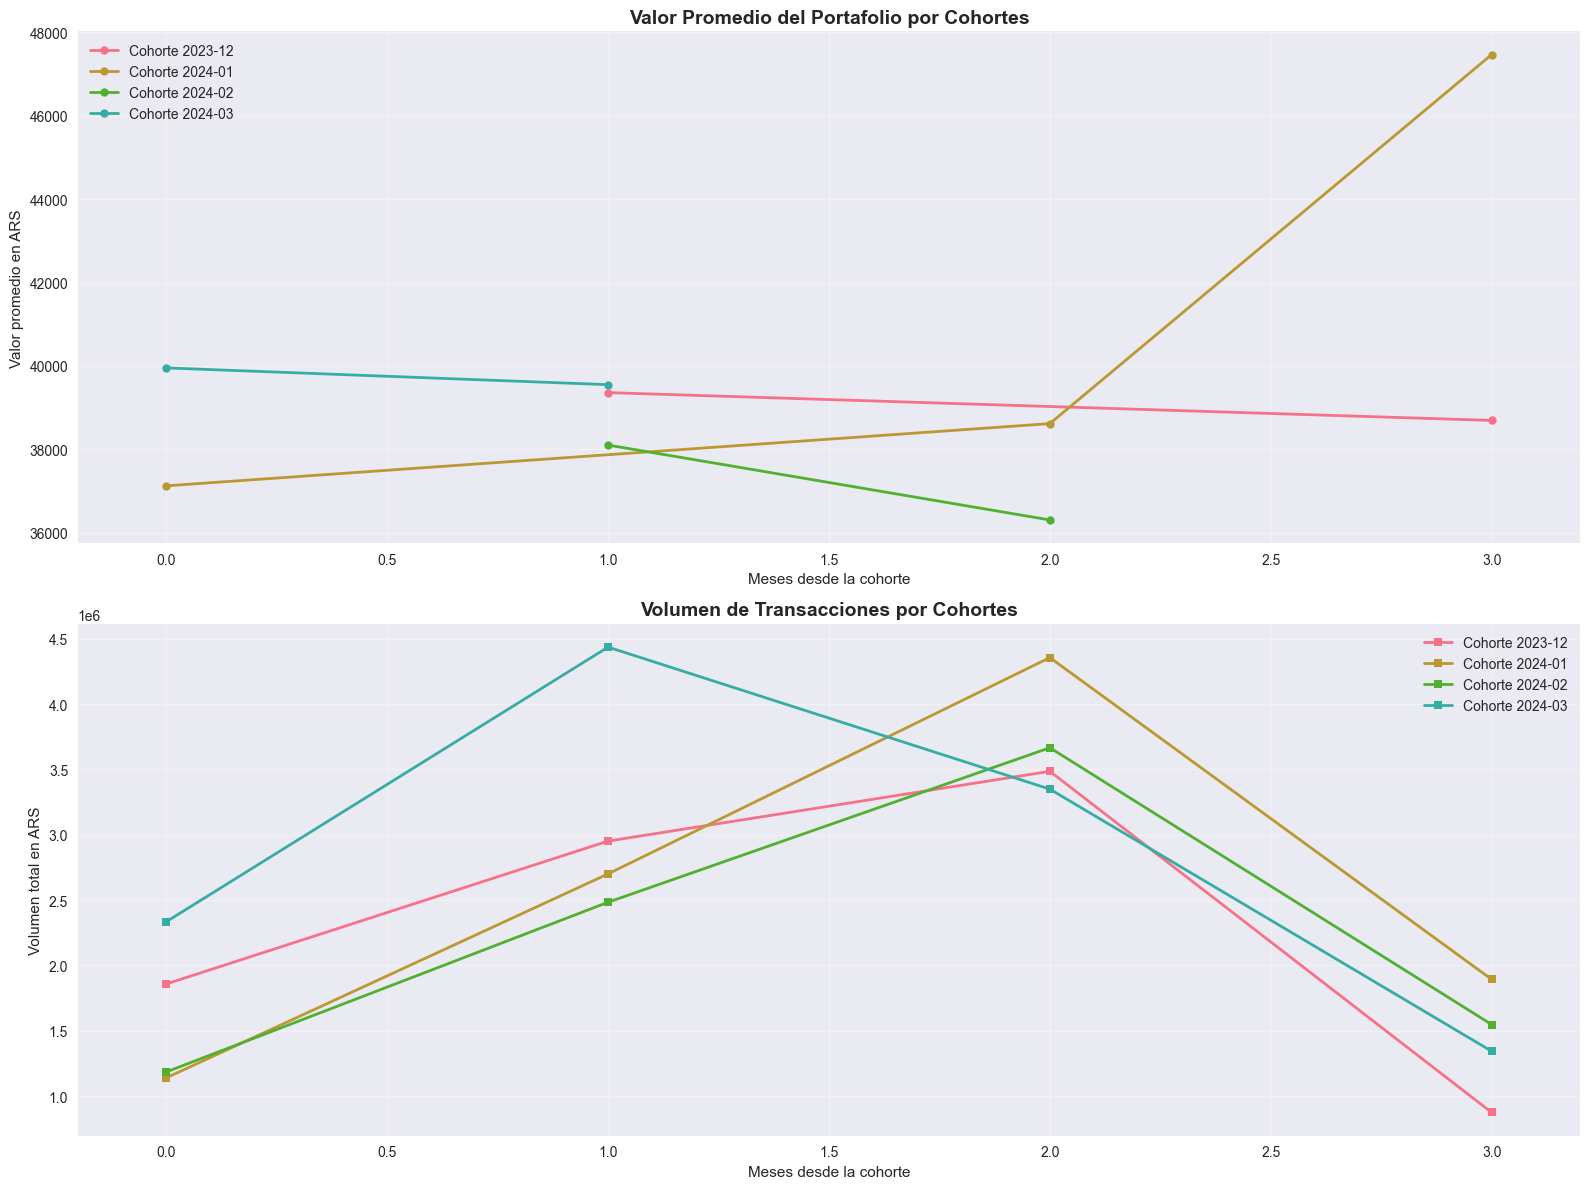


ANÁLISIS DE COMPLETITUD DE DATOS:

 Cohorte 2024-03:
   - Meses con portfolio: [0, 1]
   - Meses con transacciones: [0, 1, 2, 3]
   - Total usuarios: N/D

 Cohorte 2024-01:
   - Meses con portfolio: [0, 2, 3]
   - Meses con transacciones: [0, 1, 2, 3]
   - Total usuarios: N/D

 Cohorte 2023-12:
   - Meses con portfolio: [1, 3]
   - Meses con transacciones: [0, 1, 2, 3]
   - Total usuarios: N/D

 Cohorte 2024-02:
   - Meses con portfolio: [1, 2]
   - Meses con transacciones: [0, 1, 2, 3]
   - Total usuarios: N/D


In [84]:
# Análisis de valor por cohorte 
print("ANÁLISIS DE VALOR GENERADO POR COHORTES")
print("=" * 60)

# 1. Valor promedio del portafolio por cohorte
print("\nValor promedio del portafolio por cohorte:")
print("=" * 50)

# Verificar que estas variables estén definidas
print("🔍 Verificando variables necesarias:")
print(f"portfolio_values existe: {'portfolio_values' in locals()}")
print(f"transaction_volumes existe: {'transaction_volumes' in locals()}")
print(f"portfolio_df existe: {'portfolio_df' in locals()}")
print(f"accounts_df existe: {'accounts_df' in locals()}")

# Crear dataset completo con todas las combinaciones cohorte-mes
all_cohorts = portfolio_df['cohort_month'].unique()
all_months = range(0, 4)  # 0, 1, 2, 3 meses

# Crear grid completo
portfolio_grid = []
for cohort in all_cohorts:
    for month in all_months:
        portfolio_grid.append({
            'cohort_month': cohort,
            'months_since_cohort': month
        })

portfolio_grid_df = pd.DataFrame(portfolio_grid)

# Merge con datos reales
portfolio_complete = portfolio_grid_df.merge(
    portfolio_values, 
    on=['cohort_month', 'months_since_cohort'], 
    how='left'
).fillna(0)

# Agregar información de cohorte
users_per_cohort = accounts_df.groupby('cohort_month')['id_account'].nunique().reset_index()
users_per_cohort = users_per_cohort.rename(columns={'id_account': 'total_users'})
portfolio_complete = portfolio_complete.merge(
    users_per_cohort,
    on='cohort_month', how='left'
)

# --- CORRECCIÓN: Asegurarse de que la columna 'total_users' existe antes de usarla en .agg ---
# Si por alguna razón 'total_users' no está en las columnas, agregarla con NaN
if 'total_users' not in portfolio_complete.columns:
    portfolio_complete['total_users'] = np.nan

# Calcular estadísticas por cohorte
# Evitar el uso de columnas multi-nivel para evitar problemas de .name
# Usar .first() para 'total_users' solo si la columna existe
agg_dict = {
    'Valor_Promedio': ('avg_value', 'mean'),
    'Valor_Total': ('avg_value', 'sum'),
    'Meses_Con_Datos': ('avg_value', 'count')
}
if 'total_users' in portfolio_complete.columns:
    agg_dict['Total_Usuarios'] = ('total_users', 'first')

portfolio_summary = (
    portfolio_complete
    .groupby('cohort_month')
    .agg(**agg_dict)
    .round(2)
)

if 'Total_Usuarios' in portfolio_summary.columns:
    portfolio_summary['Valor_Por_Usuario'] = (portfolio_summary['Valor_Total'] / portfolio_summary['Total_Usuarios']).round(2)
else:
    portfolio_summary['Valor_Por_Usuario'] = np.nan

print("📊 Resumen por cohorte:")
display(portfolio_summary)

# 2. Volumen de transacciones por cohorte (CORREGIDO)
print("\nVolumen de transacciones por cohorte:")
print("=" * 50)

# Crear grid completo para transacciones
transaction_grid = []
for cohort in all_cohorts:
    for month in all_months:
        transaction_grid.append({
            'cohort_month': cohort,
            'months_since_cohort': month
        })

transaction_grid_df = pd.DataFrame(transaction_grid)

# Merge con datos reales
transaction_complete = transaction_grid_df.merge(
    transaction_volumes, 
    on=['cohort_month', 'months_since_cohort'], 
    how='left'
).fillna(0)

# Agregar información de cohorte
transaction_complete = transaction_complete.merge(
    users_per_cohort,
    on='cohort_month', how='left'
)

# --- CORRECCIÓN: Asegurarse de que la columna 'total_users' existe antes de usarla en .agg ---
if 'total_users' not in transaction_complete.columns:
    transaction_complete['total_users'] = np.nan

# Calcular estadísticas por cohorte
agg_dict_tx = {
    'Volumen_Total': ('total_volume', 'sum'),
    'Volumen_Promedio': ('total_volume', 'mean'),
    'Total_Transacciones': ('transaction_count', 'sum')
}
if 'total_users' in transaction_complete.columns:
    agg_dict_tx['Total_Usuarios'] = ('total_users', 'first')

transaction_summary = (
    transaction_complete
    .groupby('cohort_month')
    .agg(**agg_dict_tx)
    .round(2)
)
if 'Total_Usuarios' in transaction_summary.columns:
    transaction_summary['Volumen_Por_Usuario'] = (transaction_summary['Volumen_Total'] / transaction_summary['Total_Usuarios']).round(2)
else:
    transaction_summary['Volumen_Por_Usuario'] = np.nan

print("Resumen de transacciones por cohorte:")
display(transaction_summary)

# 3. Gráfico CORREGIDO de valor generado por cohorte
plt.figure(figsize=(16, 12))

# Subplot 1: Valor del portafolio (CORREGIDO)
plt.subplot(2, 1, 1)

# Solo mostrar cohortes con datos suficientes
cohorts_with_data = portfolio_complete.groupby('cohort_month')['avg_value'].sum()
cohorts_with_data = cohorts_with_data[cohorts_with_data > 0].index

for cohort in cohorts_with_data:
    data = portfolio_complete[portfolio_complete['cohort_month'] == cohort].sort_values('months_since_cohort')
    # Solo mostrar líneas con datos reales
    data_with_values = data[data['avg_value'] > 0]
    if len(data_with_values) > 0:
        plt.plot(data_with_values['months_since_cohort'], data_with_values['avg_value'], 
                marker='o', linewidth=2, label=f'Cohorte {cohort}', markersize=6)

plt.title('Valor Promedio del Portafolio por Cohortes', fontweight='bold', fontsize=14)
plt.xlabel('Meses desde la cohorte')
plt.ylabel('Valor promedio en ARS')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-0.2, 3.2)  # Ajustar límites del eje X

# Subplot 2: Volumen de transacciones
plt.subplot(2, 1, 2)

# Solo mostrar cohortes con datos suficientes
cohorts_with_transactions = transaction_complete.groupby('cohort_month')['total_volume'].sum()
cohorts_with_transactions = cohorts_with_transactions[cohorts_with_transactions > 0].index

for cohort in cohorts_with_transactions:
    data = transaction_complete[transaction_complete['cohort_month'] == cohort].sort_values('months_since_cohort')
    # Solo mostrar líneas con datos reales
    data_with_values = data[data['total_volume'] > 0]
    if len(data_with_values) > 0:
        plt.plot(data_with_values['months_since_cohort'], data_with_values['total_volume'], 
                marker='s', linewidth=2, label=f'Cohorte {cohort}', markersize=6)

plt.title('Volumen de Transacciones por Cohortes', fontweight='bold', fontsize=14)
plt.xlabel('Meses desde la cohorte')
plt.ylabel('Volumen total en ARS')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-0.2, 3.2)  # Ajustar límites del eje X

plt.tight_layout()
plt.show()

# 4. Análisis de completitud de datos
print("\nANÁLISIS DE COMPLETITUD DE DATOS:")
print("=" * 50)

for cohort in all_cohorts:
    portfolio_data = portfolio_complete[portfolio_complete['cohort_month'] == cohort]
    transaction_data = transaction_complete[transaction_complete['cohort_month'] == cohort]
    
    portfolio_months = portfolio_data[portfolio_data['avg_value'] > 0]['months_since_cohort'].tolist()
    transaction_months = transaction_data[transaction_data['total_volume'] > 0]['months_since_cohort'].tolist()
    
    print(f"\n Cohorte {cohort}:")
    print(f"   - Meses con portfolio: {sorted(portfolio_months)}")
    print(f"   - Meses con transacciones: {sorted(transaction_months)}")
    if 'total_users' in portfolio_data.columns and not portfolio_data['total_users'].isnull().all():
        print(f"   - Total usuarios: {portfolio_data['total_users'].iloc[0]}")
    else:
        print(f"   - Total usuarios: N/D")

ANÁLISIS DE PATRONES DE COMPORTAMIENTO

Distribución de tipos de transacciones por cohorte:


type,card_spend,currency_exchange,deposit,invest,withdrawal
cohort_month,,,,,
2023-12,-67.94,0.0,98.17,100.33,-30.56
2024-01,-58.81,0.0,93.72,94.62,-29.52
2024-02,-49.76,0.0,79.57,94.55,-24.37
2024-03,-54.36,0.0,91.75,88.36,-25.75


<Figure size 1500x800 with 0 Axes>

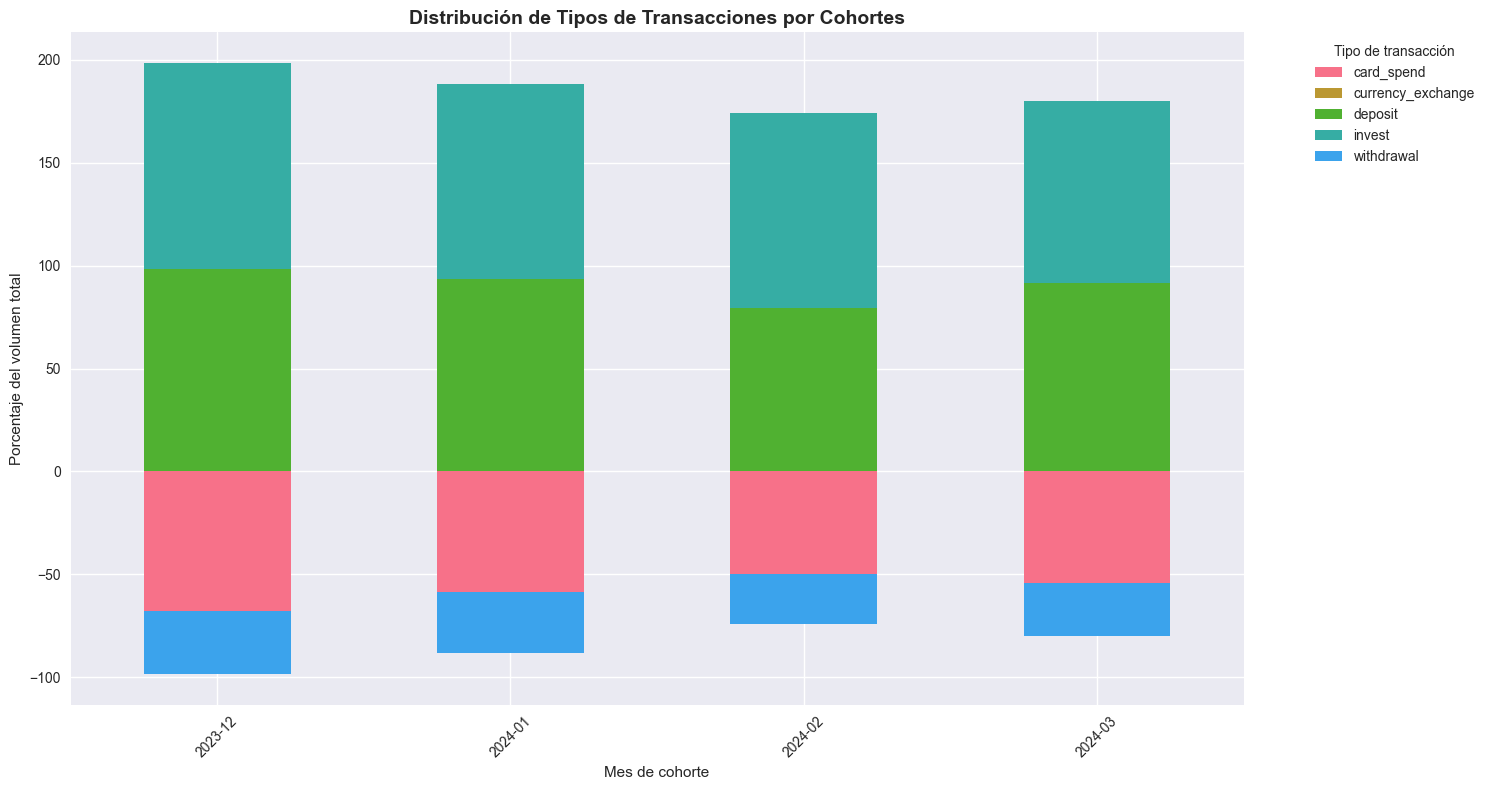


Distribución de instrumentos por cohorte:


instrument_type,bond,stablecoin_usdc,stock
cohort_month,,,
2023-12,36.15,31.04,32.82
2024-01,35.00,30.57,34.43
2024-02,27.53,32.75,39.71
2024-03,34.05,34.80,31.15


<Figure size 1500x800 with 0 Axes>

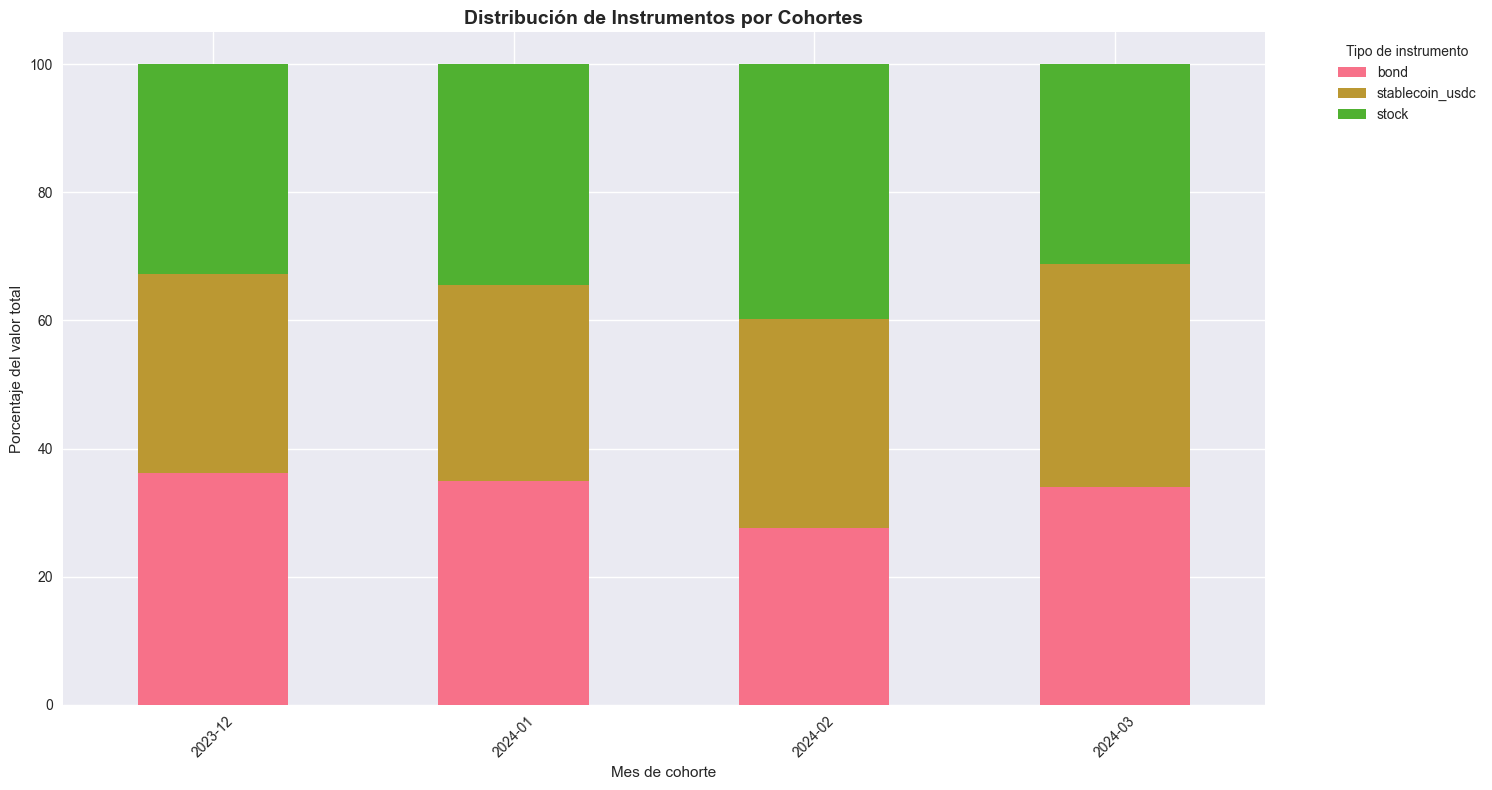

In [85]:
# Análisis de patrones de comportamiento
print("ANÁLISIS DE PATRONES DE COMPORTAMIENTO")
print("=" * 60)

# 1. Tipos de transacciones por cohorte
print("\nDistribución de tipos de transacciones por cohorte:")
transaction_types_by_cohort = transactions_df.groupby(['cohort_month', 'type'])['amount_ars'].sum().reset_index()
transaction_types_pivot = transaction_types_by_cohort.pivot(index='cohort_month', columns='type', values='amount_ars').fillna(0)

# Calcular porcentajes
transaction_types_pct = transaction_types_pivot.div(transaction_types_pivot.sum(axis=1), axis=0) * 100
display(transaction_types_pct.round(2))

# 2. Gráfico de tipos de transacciones por cohorte
plt.figure(figsize=(15, 8))
transaction_types_pct.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Distribución de Tipos de Transacciones por Cohortes', fontweight='bold', fontsize=14)
plt.xlabel('Mes de cohorte')
plt.ylabel('Porcentaje del volumen total')
plt.legend(title='Tipo de transacción', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Análisis de instrumentos por cohorte
print("\nDistribución de instrumentos por cohorte:")
instruments_by_cohort = portfolio_df.groupby(['cohort_month', 'instrument_type'])['value_ars'].sum().reset_index()
instruments_pivot = instruments_by_cohort.pivot(index='cohort_month', columns='instrument_type', values='value_ars').fillna(0)

# Calcular porcentajes
instruments_pct = instruments_pivot.div(instruments_pivot.sum(axis=1), axis=0) * 100
display(instruments_pct.round(2))

# 4. Gráfico de instrumentos por cohorte
plt.figure(figsize=(15, 8))
instruments_pct.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Distribución de Instrumentos por Cohortes', fontweight='bold', fontsize=14)
plt.xlabel('Mes de cohorte')
plt.ylabel('Porcentaje del valor total')
plt.legend(title='Tipo de instrumento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
# Identificar cohortes de alto rendimiento
print("IDENTIFICACIÓN DE COHORTES DE ALTO RENDIMIENTO")
print("=" * 70)

# 1. Ranking de cohortes por retención a los 3 meses
print("\nRanking de cohortes por retención a los 3 meses:")
retention_3m = retention_matrix[3].sort_values(ascending=False).head(10)
for i, (cohort, retention) in enumerate(retention_3m.items(), 1):
    print(f"{i:2d}. Cohorte {cohort}: {retention:.1f}%")

# 2. Ranking de cohortes por valor generado a los 3 meses
print("\nRanking de cohortes por valor generado a los 3 meses:")
value_3m = portfolio_values[portfolio_values['months_since_cohort'] == 3].sort_values('avg_value', ascending=False).head(10)
for i, (_, row) in enumerate(value_3m.iterrows(), 1):
    print(f"{i:2d}. Cohorte {row['cohort_month']}: ${row['avg_value']:,.2f} ARS")

# 3. Ranking de cohortes por volumen de transacciones a los 3 meses
print("\nRanking de cohortes por volumen de transacciones a los 3 meses:")
volume_3m = transaction_volumes[transaction_volumes['months_since_cohort'] == 3].sort_values('total_volume', ascending=False).head(10)
for i, (_, row) in enumerate(volume_3m.iterrows(), 1):
    print(f"{i:2d}. Cohorte {row['cohort_month']}: ${row['total_volume']:,.2f} ARS")



IDENTIFICACIÓN DE COHORTES DE ALTO RENDIMIENTO

Ranking de cohortes por retención a los 3 meses:
 1. Cohorte 2024-01: 59.1%
 2. Cohorte 2024-03: 58.3%
 3. Cohorte 2024-02: 55.9%
 4. Cohorte 2023-12: 47.3%

Ranking de cohortes por valor generado a los 3 meses:
 1. Cohorte 2024-01: $47,465.31 ARS
 2. Cohorte 2023-12: $38,693.01 ARS

Ranking de cohortes por volumen de transacciones a los 3 meses:
 1. Cohorte 2024-01: $1,892,849.00 ARS
 2. Cohorte 2024-02: $1,547,500.00 ARS
 3. Cohorte 2024-03: $1,343,175.00 ARS
 4. Cohorte 2023-12: $874,454.00 ARS


In [87]:
# 4. Análisis de cohortes top performers
print("\nAnálisis de cohortes top performers:")
top_cohorts = retention_3m.head(3).index.tolist()

print(top_cohorts)

for cohort in top_cohorts:
    print(f"\nCohorte {cohort} (Top performer):")
    
    # Retención
    cohort_retention = retention_matrix.loc[cohort]
    print(f"   - Retención: {cohort_retention[3]:.1f}% a los 3 meses")
    
    # Valor del portafolio
    cohort_portfolio = portfolio_values[
        (portfolio_values['cohort_month'] == cohort) &
        (portfolio_values['months_since_cohort'] == 3)
    ]
    if not cohort_portfolio.empty:
        avg_value_3m = cohort_portfolio['avg_value'].iloc[0]
        print(f"   - Valor promedio del portafolio a los 3 meses: ${avg_value_3m:,.2f} ARS")
    else:
        print("   - Valor promedio del portafolio a los 3 meses: N/D")
    
    # Tipos de transacciones
    if cohort in transaction_types_pivot.index:
        cohort_transactions = transaction_types_pivot.loc[cohort]
        top_transaction_type = cohort_transactions.idxmax()
        print(f"   - Tipo de transacción más frecuente: {top_transaction_type}")
    else:
        print("   - Tipo de transacción más frecuente: N/D")
    
    # Instrumentos preferidos
    if cohort in instruments_pivot.index:
        cohort_instruments = instruments_pivot.loc[cohort]
        top_instrument = cohort_instruments.idxmax()
        print(f"   - Instrumento preferido: {top_instrument}")
    else:
        print("   - Instrumento preferido: N/D")


Análisis de cohortes top performers:
[Period('2024-01', 'M'), Period('2024-03', 'M'), Period('2024-02', 'M')]

Cohorte 2024-01 (Top performer):
   - Retención: 59.1% a los 3 meses
   - Valor promedio del portafolio a los 3 meses: $47,465.31 ARS
   - Tipo de transacción más frecuente: invest
   - Instrumento preferido: bond

Cohorte 2024-03 (Top performer):
   - Retención: 58.3% a los 3 meses
   - Valor promedio del portafolio a los 3 meses: N/D
   - Tipo de transacción más frecuente: deposit
   - Instrumento preferido: stablecoin_usdc

Cohorte 2024-02 (Top performer):
   - Retención: 55.9% a los 3 meses
   - Valor promedio del portafolio a los 3 meses: N/D
   - Tipo de transacción más frecuente: invest
   - Instrumento preferido: stock


In [92]:
# Análisis de conclusiones
print("CONCLUSIONES Y RECOMENDACIONES")
print("=" * 60)

# 1. Resumen de hallazgos principales
print("\nHALLAZGOS PRINCIPALES:")
print("=" * 40)

# NOTA sobre calidad de datos de portafolio:
print("   [!] Nota: Existen cuentas creadas después de ciertas fechas de corte,")
print("       por lo que los datos de portafolio pueden estar incompletos o ser nulos")
print("       para esas cohortes más recientes. Esto puede afectar los valores promedio")
print("       y totales reportados en los análisis de portafolio para esos grupos.\n")

# Mejor cohorte por retención ACUMULATIVA del portafolio
best_portfolio_retention_cohort = cumulative_portfolio_retention[cumulative_portfolio_retention['months_since_cohort'] == 3]['cumulative_retention_rate'].idxmax()
best_portfolio_retention_rate = cumulative_portfolio_retention[cumulative_portfolio_retention['months_since_cohort'] == 3]['cumulative_retention_rate'].max()
print(f"   - Mejor cohorte por retención ACUMULATIVA del portafolio: {best_portfolio_retention_cohort} ({best_portfolio_retention_rate:.1f}%)")

# Mejor cohorte por retención
best_retention_cohort = retention_matrix[3].idxmax()
best_retention_rate = retention_matrix[3].max()
print(f"   - Mejor cohorte por retención: {best_retention_cohort} ({best_retention_rate:.1f}%)")

# Mejor cohorte por valor
best_value_cohort = portfolio_values[portfolio_values['months_since_cohort'] == 3].set_index('cohort_month')['avg_value'].idxmax()
best_value = portfolio_values[(portfolio_values['months_since_cohort'] == 3) & (portfolio_values['cohort_month'] == best_value_cohort)]['avg_value'].iloc[0]
print(f"   - Mejor cohorte por valor: {best_value_cohort} (${best_value:,.2f} ARS)")

# Mejor cohorte por volumen
best_volume_row = transaction_volumes[transaction_volumes['months_since_cohort'] == 3].set_index('cohort_month')['total_volume'].idxmax()
best_volume = transaction_volumes[(transaction_volumes['months_since_cohort'] == 3) & (transaction_volumes['cohort_month'] == best_volume_row)]['total_volume'].iloc[0]
print(f"   - Mejor cohorte por volumen: {best_volume_row} (${best_volume:,.2f} ARS)")

# 2. Patrones identificados
print("\nPATRONES IDENTIFICADOS:")
print("=" * 40)

# Correlación entre retención y valor
# Unimos los índices para asegurar alineación y evitar NaN
ret_3 = retention_matrix[3]
val_3 = portfolio_values[portfolio_values['months_since_cohort'] == 3].set_index('cohort_month')['avg_value']
common_cohorts = ret_3.index.intersection(val_3.index)
ret_3 = ret_3.loc[common_cohorts]
val_3 = val_3.loc[common_cohorts]
retention_value_corr = ret_3.corr(val_3)
print(f"   - Correlación retención-valor: {retention_value_corr:.3f}")

# Análisis de tipos de transacciones en cohortes exitosas
print(f"   - Tipos de transacciones en cohortes exitosas:")
for cohort in top_cohorts:
    top_transaction = transaction_types_pivot.loc[cohort].idxmax()
    print(f"     * Cohorte {cohort}: {top_transaction}")

CONCLUSIONES Y RECOMENDACIONES

HALLAZGOS PRINCIPALES:
   [!] Nota: Existen cuentas creadas después de ciertas fechas de corte,
       por lo que los datos de portafolio pueden estar incompletos o ser nulos
       para esas cohortes más recientes. Esto puede afectar los valores promedio
       y totales reportados en los análisis de portafolio para esos grupos.

   - Mejor cohorte por retención ACUMULATIVA del portafolio: 3 (100.0%)
   - Mejor cohorte por retención: 2024-01 (59.1%)
   - Mejor cohorte por valor: 2024-01 ($47,465.31 ARS)
   - Mejor cohorte por volumen: 2024-01 ($1,892,849.00 ARS)

PATRONES IDENTIFICADOS:
   - Correlación retención-valor: 1.000
   - Tipos de transacciones en cohortes exitosas:
     * Cohorte 2024-01: invest
     * Cohorte 2024-03: deposit
     * Cohorte 2024-02: invest


In [91]:
# 3. Recomendaciones adaptadas al análisis

print("\nRECOMENDACIONES BASADAS EN EL ANÁLISIS DE COHORTES:")
print("=" * 50)

print(f"   1. Foco en cohortes con mejor retención y valor (ej: cohortes de {best_retention_cohort}):")
print("      - Analizar qué acciones, productos o comunicaciones recibieron estas cohortes.")
print("      - Replicar y escalar esas prácticas en cohortes nuevas.")

print("   2. Incentivar la actividad en los primeros 3 meses:")
print("      - La retención cae significativamente después del 3er mes.")
print("      - Ofrecer beneficios, desafíos o recompensas para mantener la participación en ese período crítico.")
print("   3. Promover productos/instrumentos preferidos por cohortes exitosas:")
for cohort in top_cohorts:
    if cohort in instruments_pivot.index:
        top_instrument = instruments_pivot.loc[cohort].idxmax()
        print(f"      - En la cohorte {cohort}, el instrumento más usado es: {top_instrument}. Potenciar su visibilidad y acceso.")
print("      - Personalizar la oferta de productos según el perfil de cada cohorte.")

print("   4. Monitoreo y alertas tempranas con umbrales de alerta:")
print("      - Implementar seguimiento mensual de retención y volumen por cohorte usando los dataframes de retención y transacciones.")
print("      - Definir un umbral de alerta: por ejemplo, si la retención de una cohorte cae más de 20 puntos porcentuales respecto al mes anterior, disparar una alerta temprana.")
print("      - Ejemplo: Cohortes con caída de retención >20pp entre meses consecutivos:")
for cohort in retention_matrix.index:
    drops = retention_matrix.loc[cohort].diff().fillna(0)
    if (drops[1:] < -20).any():
        print(f"        * Cohorte {cohort}: caída abrupta detectada en meses {[i for i, v in drops[1:].items() if v < -20]}")

print("   5. Mejorar onboarding y comunicación según el mes de alta y datos observados:")
print("      - Ajustar mensajes y tutoriales según el contexto temporal y el comportamiento real de cada cohorte (por ejemplo, si una cohorte muestra baja retención inicial, reforzar el onboarding).")
print("      - Aprovechar los meses con mejores resultados (identificados en los dataframes) para lanzar campañas de adquisición o referidos.")

print("\nAnálisis de cohortes completado")


RECOMENDACIONES BASADAS EN EL ANÁLISIS DE COHORTES:
   1. Foco en cohortes con mejor retención y valor (ej: cohortes de 2024-01):
      - Analizar qué acciones, productos o comunicaciones recibieron estas cohortes.
      - Replicar y escalar esas prácticas en cohortes nuevas.
   2. Incentivar la actividad en los primeros 3 meses:
      - La retención cae significativamente después del 3er mes.
      - Ofrecer beneficios, desafíos o recompensas para mantener la participación en ese período crítico.
   3. Promover productos/instrumentos preferidos por cohortes exitosas:
      - En la cohorte 2024-01, el instrumento más usado es: bond. Potenciar su visibilidad y acceso.
      - En la cohorte 2024-03, el instrumento más usado es: stablecoin_usdc. Potenciar su visibilidad y acceso.
      - En la cohorte 2024-02, el instrumento más usado es: stock. Potenciar su visibilidad y acceso.
      - Personalizar la oferta de productos según el perfil de cada cohorte.
   4. Monitoreo y alertas tempra